## 청라, 송도지역 미세먼지 측정값 스크래핑
> 1. 송도 = https://bit.ly/2EWi9vM
> 1. 청라 = https://bit.ly/2Al7h6y

* Todo: 계측 센서 갯수가 다르므로 필터링 방식이 달라져야 한다
* 송도 = 6개 / 청라 = 4개

In [1]:
"""
* 청라, 송도지역 미세먼지 측정값 스크래핑
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup

In [2]:
URLS = [
    'http://air.incheon.go.kr/airinch/real3.html?area_other_index=999991',
    'http://air.incheon.go.kr/airinch/real3.html?area_other_index=999992',
]

""" 주의!: 송도와 청라는 데이터 갯수가 틀려서 필터링 방법을 달리해야 함. """
URL = URLS[0]  # 0=청라 - 측정치 1+3 = 4개
URL = URLS[1]  # 1=송도 - 측정치 1+6 = 7개

RESPONSE = requests.get(URL)
SOUP = BeautifulSoup(RESPONSE.content, 'html.parser')
TABLE = SOUP.find_all('table', {'class': 'view'})

TDS = TABLE[0].find_all('td')
FONTS = TABLE[0].find_all('font')
SPANS = TABLE[0].find_all('span')

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


## 데이터의 길이를 기준으로 구분한다 (EDA)
> 12자 길이를 넘어가는 데이터는 한글 테이터이다.

In [25]:
for n, span in enumerate(SPANS, 0):
    neat_span = str(span.text).strip()

In [4]:
DATA = []
DATE = []

for n, span in enumerate(SPANS, 0):
    neat_span = str(span.text).strip()

    if len(neat_span) > 12:                           # 2018년12월 29일24시
        """ 날짜와 시간을 분리해서 각각 넣는다 """
        DATE.append(neat_span[:-3])     # 날짜 = 2018년 12월 29일
        DATA.append(neat_span[-3:])     # 시간 = '24시'  .. 날짜는 잘라내고, 시간만 넣는다
    else:
        DATA.append(neat_span)          # 그렇지 않으면 그냥 넣는다

""" 리스트에 담긴 해당 날짜를 보여준다, 그래봤자 2개 지만.. """
1. print(DATE[0])                          # 2018년12월 30일  ... 오늘날짜가 먼저 담긴다.
1. print(DATE[1])                          # 2018년12월 29일  ... 어제날짜가 다음에 담긴다.

In [5]:
""" 데이터가 7줄씩 한줄로 쌓인다.  확인해 보자 """
DATA    # ['시간','측정항목','SO2(ppm)','NO2(ppm)','O3(ppm)','CO(ppm)','PM10(㎍/㎥)','PM2.5(㎍/㎥)',
FULL_COLUMNS = ['Time(24Hr)',]
FULL_COLUMNS.extend(DATA[2:8])  # ['Time(24Hr)','SO2(ppm)', ... 'CO(ppm)','PM10(㎍/㎥)','PM2.5(㎍/㎥)']

## COLUMNS, UNIT, TIME_COLS
1. COLUMNS = ['Time', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'],
1. UNITS = ['24Hr', 'ppm', 'ppm', 'ppm', 'ppm', '㎍/㎥', '㎍/㎥'])    
1. TIME_COLS = ['01', '02', ... '12', '01',]

In [6]:
COLUMNS = []
UNITS = []

for item in FULL_COLUMNS:      # full 컬럼값에서 '타이틀'과 '단위'를 분리해 냄
    title = item.split('(')[0]    # Title
    _rest = item.split('(')[1]
    
    COLUMNS.append(title)
    UNITS.append(_rest[:-1])

In [7]:
CUT_DATA = DATA[8:]                       # 앞 부분(index header)을 잘라내고 데이터부분만 남김 =  1-DIM
DATA_NP = np.array(CUT_DATA)              # numpy 데이터 변환!
DATA_NP2D = np.reshape(DATA_NP, (-1,7))   # 1D to 2D 변환 (-1,7)
# np.shape(a=DATA_NP2D)                     # (26,7)  ... 그때 그때 행이 바뀜, 최대 24~ 48까지

In [8]:
TIME_COLS = DATA_NP2D[:,0]                         # 시간열만 쪼개서 따로 담음 .. '08시'
DATA_NP2D[:,0] = [time[:2] for time in TIME_COLS]  # 02시 --> 02, 앞 두글자만 잘라냄

In [9]:
# DATA_NP2D (String) 은 원본으로 남겨두고, Float 숫자로 변환하여 AIR_DATA_NP로 변경 
# AIR_DATA_NP = np.asfarray(DATA_NP2D, dtype=np.float)  # 문자열 --> float 로 변경해 줌(1)
AIR_DATA_NP = DATA_NP2D.astype(np.float64)            # 문자열 --> float 로 변경해 줌(2)

In [10]:
# Pandas DataFrame 오브젝트로 변경한다.
# df.index = df.Time      # 인덱스를 타임으로 변경함  .... 인덱스는 UID 중복 불가함(에러)

# df = df.drop('column_name', 1)
# where 1 is the axis number (0 for rows and 1 for columns.)
# df = df.drop('Time', 1) # 1=axis (column) / 0=rows  .... 1컬럼을 삭제하는 방법

df = pd.DataFrame(AIR_DATA_NP, columns=COLUMNS)

In [11]:
# df.Time = 19.0 .. np.float64
# TIME_COLS #array(['19', '18', '17', '16', '15'  ... Str


In [12]:
# 그래프 함수의 정의

def df_plot(df_column):
    plt.plot(df_column)
    """ 그래프에 텍스트를 입히는 옵션 """
    plt.title("DATA PLOTTING")        # 타이틀
    plt.xlabel(COLUMNS[:1])                      # x 라벨
    plt.ylabel(df_column.name)                   # y 라벨
    plt.legend()
    plt.xticks(df.index.values, TIME_COLS)
    
def df_hist(df_column):
    plt.hist(df_column)
    """ 그래프에 텍스트를 입히는 옵션 """
    plt.title("DATA HISTOGRAM")        # 타이틀
    plt.xlabel(COLUMNS[:1])                      # x 라벨
    plt.ylabel(df_column.name)                   # y 라벨
    
    
def df_scatter(df_col1, df_col2):
    plt.scatter(df_col1, df_col2,alpha=0.2)
    """ 그래프에 텍스트를 입히는 옵션 """
    plt.title(
        "SCATTER CHART with {},{}".format(
            df_col1.name, 
            df_col2.name,))        # 타이틀
    plt.xlabel(df_col2.name)                     # x 라벨
    plt.ylabel(df_col1.name)                     # y 라벨

def df_flip_x():
    plt.gca().invert_xaxis()

def df_flip_y():
    plt.gca().invert_yaxis()
    
def df_flip_all():
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
def plot_2charts(data_series, xlabel):  
    """
    # 히스토그램 + 박스플롯을 4x4화면 윗쪽 2개로 플롯해줍니다.
    """
    plt.figure()
    plt.subplot(221)
    plt.hist(data_series)
    plt.xlabel(xlabel)
    
    plt.subplot(222)
    sns.boxplot(data_series)
    plt.show()    

## 데이터 분포형상 확인
 ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

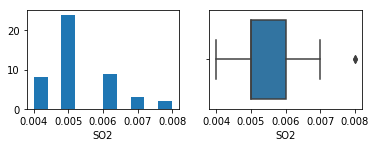

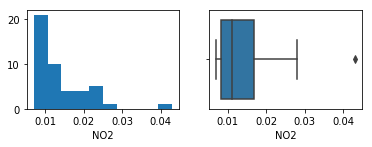

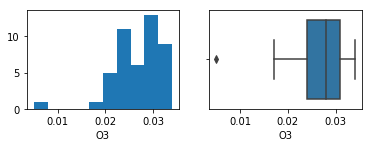

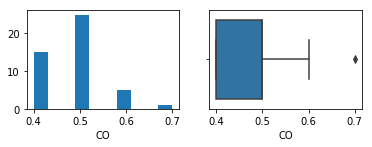

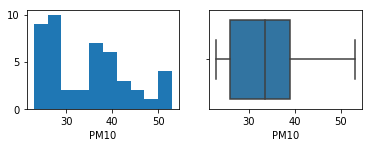

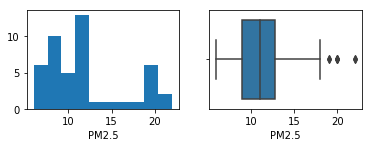

In [13]:
for item in COLUMNS[1:]:
    plot_2charts(data_series=df[item], xlabel=item)

In [14]:
# CO값 차이가 커서,(9로 나눠서 한 그래프에 표시)..['SO2', 'NO2', 'O3', 'CO_mod',]
# df 에 'NEW'칼럼 추가하기 (df.CO값을 복사해서 칸을 늘림)
df['CO_mod'] = pd.Series(df['CO'].copy() / 12, index=df.index)            # CO를    1/12
df['PM10_mod'] = pd.Series(df['PM10'].copy() / 250, index=df.index)       # PM10을  1/250
df['PM2.5_mod'] = pd.Series(df['PM2.5'].copy() / 120, index=df.index)     # PM2.5를 1/120

In [15]:
print(df.head())
print(df.describe())

   Time    SO2    NO2     O3   CO  PM10  PM2.5    CO_mod  PM10_mod  PM2.5_mod
0  22.0  0.008  0.043  0.005  0.7  42.0   22.0  0.058333     0.168   0.183333
1  21.0  0.006  0.028  0.017  0.6  38.0   20.0  0.050000     0.152   0.166667
2  20.0  0.006  0.024  0.021  0.5  36.0   19.0  0.041667     0.144   0.158333
3  19.0  0.006  0.024  0.021  0.6  32.0   18.0  0.050000     0.128   0.150000
4  18.0  0.006  0.023  0.022  0.5  38.0   20.0  0.041667     0.152   0.166667
            Time        SO2        NO2         O3         CO       PM10  \
count  46.000000  46.000000  46.000000  46.000000  46.000000  46.000000   
mean   12.021739   0.005283   0.013478   0.027000   0.482609  34.000000   
std     6.744509   0.000981   0.007244   0.005445   0.070881   8.717798   
min     1.000000   0.004000   0.007000   0.005000   0.400000  23.000000   
25%     6.250000   0.005000   0.008250   0.024000   0.400000  26.000000   
50%    12.000000   0.005000   0.011000   0.028000   0.500000  33.500000   
75%    

## 전체 센서값 동향 플로팅
 ['Time', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

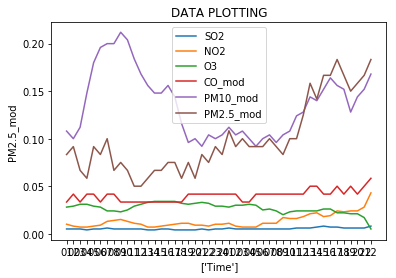

In [16]:
[df_plot(df[col]) for col in ['SO2', 'NO2', 'O3', 'CO_mod','PM10_mod', 'PM2.5_mod',]]
df_flip_x()
plt.show()

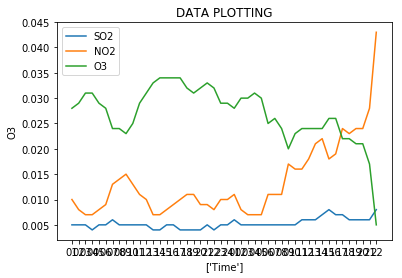

In [17]:
[df_plot(df[col]) for col in ['SO2', 'NO2', 'O3',]]
df_flip_x()
plt.show()

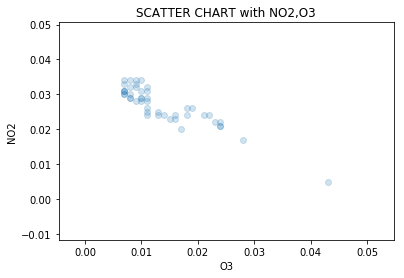

In [18]:
df_scatter(df.NO2, df.O3)
plt.show()

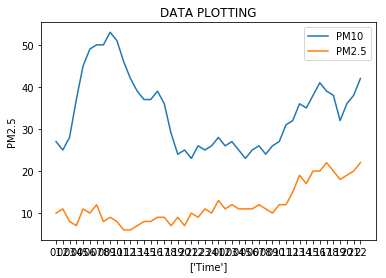

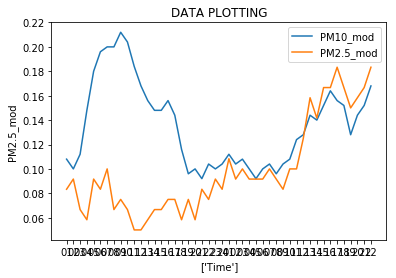

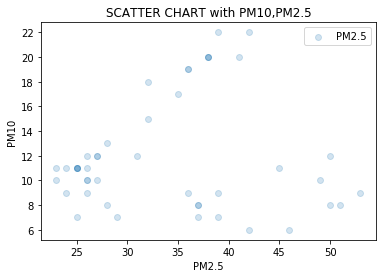

In [19]:
[df_plot(df[col]) for col in ['PM10', 'PM2.5']]
df_flip_x()
plt.show()

[df_plot(df[col]) for col in ['PM10_mod', 'PM2.5_mod']]
df_flip_x()
plt.show()

# 스케터는 플립이 필요없음!
df_scatter(df.PM10, df['PM2.5'])
plt.legend()

## 플립하지 말아야 할 그래프

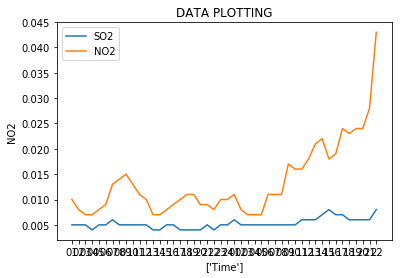

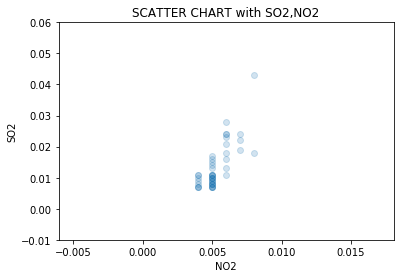

In [20]:
[df_plot(df[col]) for col in ['SO2', 'NO2']]
df_flip_x()           # x 좌표는 플립해야 함. / y좌표는 유지!
plt.show()

# 스캐터는 플립할 필요가 없음
df_scatter(df.SO2, df.NO2)
plt.show()

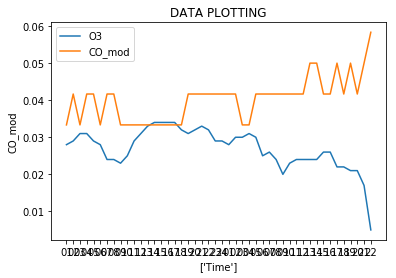

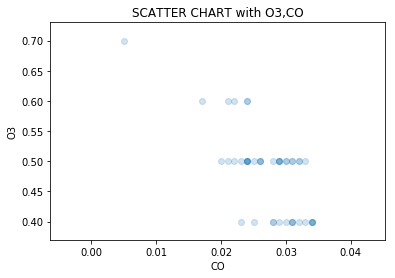

In [21]:
# 전체 플로팅 중에 관심사항만 따로 플로팅 해서 관찰하기
# [df_plot(df[col]) for col in ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']]
# plt.show()

[df_plot(df[col]) for col in ['O3', 'CO_mod',]]
df_flip_x()           # x 좌표는 플립해야 함. / y좌표는 유지!
plt.show()

# 스캐터는 플립필요없음!
df_scatter(df.O3, df.CO)
plt.show()

[None, None, None, None, None, None]

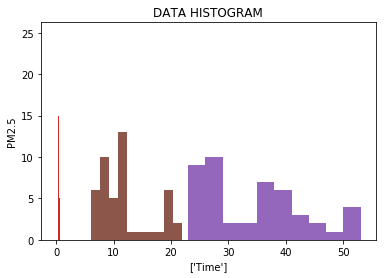

In [22]:
[df_hist(df[col]) for col in ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']]

> 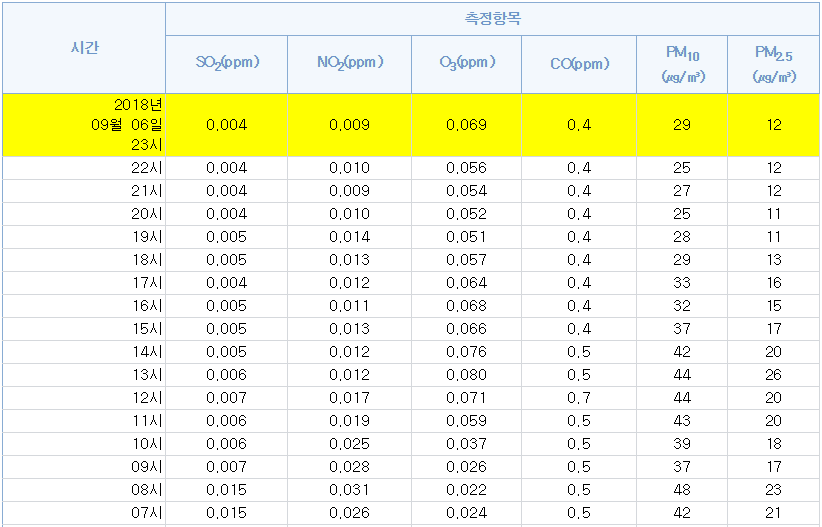

In [23]:
# Data Frame 을 엑셀로 저장한다. (CSV화일)
df.to_csv('air_incheon.csv', sep=',', encoding='utf-8')